In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 91.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 19.5 MB/s eta 0:00:00


# Import

In [2]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from transformers import BertTokenizer, TFBertModel
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Neg: 1, Neu: 2, Pos: 3
raw_data: row number [876, 880, 948]

# Mount to GDrive

In [3]:
import os
from google.colab import drive
drive.mount('/gdrive')
gdir = '../gdrive/MyDrive/models'

Mounted at /gdrive


In [4]:
os.listdir(gdir)
wkdir = f'{gdir}/vnnews_multi_bert'
print(wkdir)
# os.mkdir(wkdir)
os.listdir(wkdir)

../gdrive/MyDrive/models/vnnews_multi_bert


['variables', 'assets', 'saved_model.pb', 'keras_metadata.pb']

# Funcs

In [5]:
def DatasetMapFunction(input_ids, attn_masks, labels):
  # define the output of the whole
  return {
      'input_ids':input_ids,
      'attention_mask':attn_masks
  },labels

def generate_training_data(data, tokenizer,max_len=256):
  ids = np.zeros((len(data),max_len))
  masks = np.zeros((len(data),max_len))
  for i, text in tqdm(enumerate(data)):
    tokenized_text = tokenizer.encode_plus(
        text,
        max_length=max_len,
        truncation=True,
        padding='max_length',
        add_special_tokens=True,
        return_tensors='tf'
    )
    ids[i,:] = tokenized_text.input_ids
    masks[i,:] = tokenized_text.attention_mask
  return ids, masks

def dataset_size(dataset):
  num_elements = tf.data.experimental.cardinality(dataset).numpy()
  return num_elements

def split_dataset(df, dataset, debug = True):
  batches = df.shape[0]/15
  train_size = int((batches)*7//10)
  test_size = int(batches-train_size)
  vali_size = int(train_size*.3)
  train_size -= vali_size
  if debug:
    print(f'train: {train_size}, vali: {vali_size}, test: {test_size}')
  test_ds = dataset.take(test_size)
  Train_ds = dataset.skip(test_size)
  train_ds = Train_ds.take(train_size)
  vali_ds = Train_ds.skip(train_size)
  if debug:
    print(f'Test: {dataset_size(test_ds)}, train: {dataset_size(train_ds)}, vali: {dataset_size(vali_ds)}')
  return train_ds, vali_ds, test_ds


## Crawl

In [ ]:
def cafef_news(symbol):
  try: 
    url = 'http://s.cafef.vn/Ajax/Events_RelatedNews_New.aspx?symbol='+str(symbol)+'&floorID=0&configID=0&PageIndex=1&PageSize=10000&Type=2'
    
    data = requests.get(url)
    soup = BeautifulSoup(data.content, 'html.parser')
    data = soup.find("ul", {"class": "News_Title_Link"})
    raw = data.find_all('li')
    data_dicts = []
    for row in raw:
        row_dict = {}
        row_dict['newsdate'] = row.span.text
        row_dict['title'] = row.a.text
        row_dict['url'] = "http://s.cafef.vn/" + str(row.a['href'])
        row_dict['ticker'] = str(symbol)
        data_dicts.append(row_dict)
  except Exception as e:
    print(e)
  return data_dicts

## Visualize

In [ ]:
def plot_history(hist, metrics={
    'acc':'accuracy','val_acc':'val_accuracy',
    'loss':'loss','val_loss':'val_loss'}
    ):
  history_dict = hist.history
  print(history_dict.keys())
  acc = history_dict[metrics['acc']]
  val_acc = history_dict[metrics['val_acc']]
  loss = history_dict[metrics['loss']]
  val_loss = history_dict[metrics['val_loss']]

  epochs = range(1, len(acc) + 1)
  fig = plt.figure(figsize=(12,10))
  fig.tight_layout()

  plt.subplot(2, 1, 1)
  # r is for "solid red line"
  plt.plot(epochs, loss, 'r', label='Training loss')
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  # plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(2, 1, 2)
  plt.plot(epochs, acc, 'r', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  return

def multi_plot_stats_curve(true_labels, probs, method,title):
    """
    plots the roc curve based of the probabilities
    """
    num_label = true_labels.nunique()
    start = min(true_labels.unique())
    fpr = {}
    tpr = {}
    thresholds = {}
    colors = ['orange','green','blue','red','black']
    for label in range(start,num_label+1):
      i = label - 1# due to index transition
      fpr[i], tpr[i], thresholds[i] = method(true_labels, probs[:,i], pos_label=label)
      plt.plot(fpr[i], tpr[i], linestyle='--',color=colors[i], label=f'Class {label} vs Rest')
    plt.title(title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    return 

def multi_plot_roc_curve(true_labels, probs, method=roc_curve):
  multi_plot_stats_curve(true_labels, probs, roc_curve,'Multiclass ROC curve')
  return

## Pipelines

In [ ]:
def text_to_dataset(df, data, label, tokenizer, format_func, training=True):
  # input
  text = df[data]
  true_label = df[label]
  # tokenize
  x_input_ids, x_attn_masks = generate_training_data(text, tokenizer)
  if training: 
    n_label = true_label.nunique()
  else:
    n_label = 3
  # one hot
  labels = np.zeros((len(text),n_label))
  labels[np.arange(len(text)), true_label.values - 1] = 1
  # create dataset
  dataset = tf.data.Dataset.from_tensor_slices(
    (x_input_ids, x_attn_masks, labels))
  # change format
  dataset = dataset.map(format_func)
  return text,dataset,true_label

def train_model(df,data,label,tokenizer,bert,format_func,wkdir):
  origin_text, text_ds, true_label = text_to_dataset(df,data,label,tokenizer,format_func,True)
  # save on learing model
  filepath=f"{wkdir}/weights_20.best.hdf5"
  checkpoint = ModelCheckpoint(
    filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
  callbacks_list = [checkpoint]
  # shuffle dataset
  d_size = df.shape[0]
  text_ds = text_ds.shuffle(d_size).batch(15)
  # split dataset
  train_ds, vali_ds, test_ds = split_dataset(df, text_ds)
  # train model
  time_start = time.time()
  hist = bert.fit(train_ds,validation_data=vali_ds,epochs=20,callbacks=callbacks_list)
  time_end = time.time()
  dura = time_end - time_start
  return bert,hist,dura

def inference_text(df,data,label,tokenizer,bert,format_func):
  origin_text, text_ds, true_label = text_to_dataset(df,data,label,tokenizer, format_func,False)
  text_ds = text_ds.batch(1)
  pred_raw = bert.predict(text_ds)
  pred = np.argmax(pred_raw, axis=1)
  pred = pred+1 # due to index transition
  print(classification_report(true_label, pred))
  return origin_text,true_label,pred

def inference_probs(df,data,label,tokenizer,bert,format_func):
  ''' return the probability of the specified label 
      this function is mainly used for ROC, AUC curve
  '''
  origin_text, text_ds, true_label = text_to_dataset(df,data,label,tokenizer,format_func,False)
  text_ds = text_ds.batch(1)
  probs = bert.predict(text_ds)
  return origin_text,true_label,probs

def label_news(data, tokenizer, bert, format_func):
  # input
  text = data
  # tokenize
  x_input_ids, x_attn_masks = generate_training_data(text, tokenizer)
  n_label = 3
  # one hot
  labels = np.zeros((len(text),n_label))
  # create dataset
  dataset = tf.data.Dataset.from_tensor_slices(
    (x_input_ids, x_attn_masks, labels))
  # change format
  dataset = dataset.map(format_func)
  text_ds = dataset.batch(1)
  pred_raw = bert.predict(text_ds)
  pred = np.argmax(pred_raw, axis=1)
  pred = pred+1 # due to index transition
  return text,dataset,pred

# Dataset

In [ ]:
'https://www.youtube.com/watch?v=wp9BudYGZyA'
url = 'https://github.com/h4438/data/raw/master/raw_data.xlsx'
news_df = pd.read_excel(url)
print(news_df.head())

                                               title  label
0  "Trùm" logistics Sotrans lên kế hoạch tăng gấp...      3
1  ĐHĐCĐ SSI: "Khen ngợi CTCK thị phần số 1, nhưn...      2
2  Cổ phiếu nhóm Viettel giảm mạnh dù thị trường ...      2
3  Cổ phiếu lên đỉnh, con gái chủ tịch Haxaco (HA...      2
4  FPT: Cổ phiếu bứt phá 59%, lãi ròng 4 tháng đầ...      3


In [ ]:
print(news_df['label'].value_counts())
print(news_df.shape)

3    569
2    249
1    187
Name: label, dtype: int64
(1005, 2)


# Dowload Bert

In [ ]:
 # tokenizer multiligual bert cased
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
# model = TFBertModel.from_pretrained("bert-base-multilingual-cased")

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

## test tokenize

In [ ]:
sample = news_df['title'].iloc[12]
print(sample)

Nghe theo khuyến nghị mua cổ phiếu “tốt” vì sao vẫn thua lỗ nặng giữa uptrend?


In [ ]:
token = tokenizer.encode_plus(
    sample,
    max_length=256,
    truncation=True,
    padding='max_length',
    add_special_tokens=True,
    return_tensors='tf'
)

In [ ]:
token.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
a_token = token['input_ids'][:,:]
print(a_token.shape,'\n', a_token[:,:25])

(1, 256) 
 tf.Tensor(
[[   101  72959  11643  13951  16028 108473  40352  56944  27975 103963
     100  33598    100  17819  36993  22666  97172    180  33078  47428
   20734  10741  67137  10162    136]], shape=(1, 25), dtype=int32)


# Build Model

In [ ]:
def build_bert(bert_model, input_shape = (256,), labels=3):
  input_ids = tf.keras.layers.Input(
      shape=input_shape, name='input_ids',dtype='int32')
  attention_masks = tf.keras.layers.Input(
      shape=input_shape, name='attention_mask', dtype='int32')
  bert_embd = bert_model.bert(input_ids, attention_masks)[1] #use the pooled output
  inter_layer = tf.keras.layers.Dense(
      512,activation='relu',name='intermediate_layer')(bert_embd)
  out_layer = tf.keras.layers.Dense(
      labels,activation='softmax',name='output_layer')(inter_layer)
  model = tf.keras.Model(inputs=[input_ids, attention_masks], outputs=out_layer)
  return model

In [ ]:
my_bert = build_bert(model,input_shape=(256,),labels=3)
my_bert.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  177853440   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

## loss function

In [ ]:
optimi = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-6)
loss_func = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

In [ ]:
my_bert.compile(optimizer=optimi,loss=loss_func,metrics=[acc])

# Train model

In [ ]:
trained_bert,hist,dura = train_model(news_df,'title','label',tokenizer,my_bert,DatasetMapFunction,wkdir)

0it [00:00, ?it/s]

train: 33, vali: 13, test: 21
Test: 21, train: 33, vali: 13
Epoch 1/20
33/33 [==============================] - ETA: 0s - loss: 1.0110 - accuracy: 0.5273 
Epoch 1: val_loss improved from inf to 0.98856, saving model to ../gdrive/MyDrive/models/vnnews_multi_bert/weights_20.best.hdf5
33/33 [==============================] - 1453s 44s/step - loss: 1.0110 - accuracy: 0.5273 - val_loss: 0.9886 - val_accuracy: 0.5744
Epoch 2/20
33/33 [==============================] - ETA: 0s - loss: 0.8715 - accuracy: 0.6263 
Epoch 2: val_loss improved from 0.98856 to 0.80456, saving model to ../gdrive/MyDrive/models/vnnews_multi_bert/weights_20.best.hdf5
33/33 [==============================] - 1533s 47s/step - loss: 0.8715 - accuracy: 0.6263 - val_loss: 0.8046 - val_accuracy: 0.7026
Epoch 3/20
33/33 [==============================] - ETA: 0s - loss: 0.7738 - accuracy: 0.6848 
Epoch 3: val_loss did not improve from 0.80456
33/33 [==============================] - 1435s 43s/step - loss: 0.7738 - accuracy: 0

## evaluate model

In [ ]:
print(f"Total learning time: {dura/3600} hours")
print(gdir)

Total learning time: 8.44933501475387 hours
../gdrive/MyDrive/models


In [ ]:
my_bert.save(f'{gdir}/vnnews_multi_bert_model')

In [ ]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


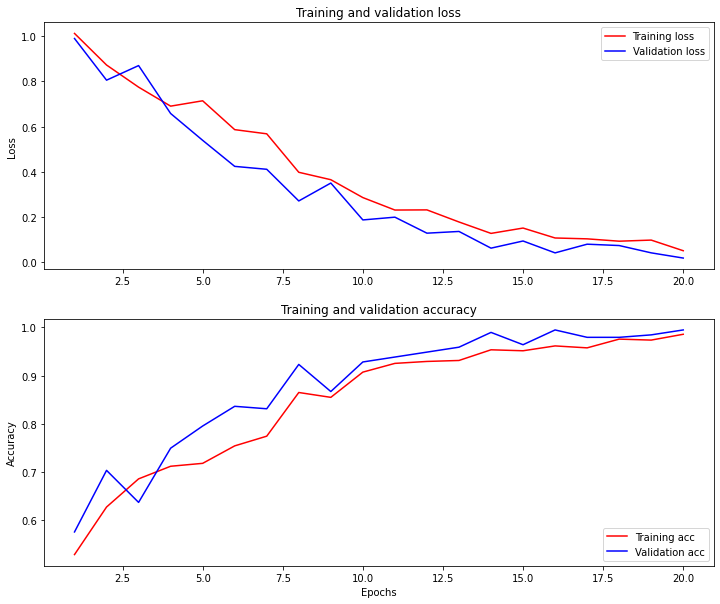

In [ ]:
plot_history(hist)

## evaluate dataset

In [ ]:
news_df.head()

,title,label
0,"""Trùm"" logistics Sotrans lên kế hoạch tăng gấp...",3
1,"ĐHĐCĐ SSI: ""Khen ngợi CTCK thị phần số 1, nhưn...",2
2,Cổ phiếu nhóm Viettel giảm mạnh dù thị trường ...,2
3,"Cổ phiếu lên đỉnh, con gái chủ tịch Haxaco (HA...",2
4,"FPT: Cổ phiếu bứt phá 59%, lãi ròng 4 tháng đầ...",3


In [ ]:
inference_text(news_df,'title','label',tokenizer,my_bert,DatasetMapFunction)

0it [00:00, ?it/s]

1005/1005 [==============================] - 896s 891ms/step
              precision    recall  f1-score   support

           1       0.98      0.98      0.98       187
           2       0.98      0.99      0.99       249
           3       1.00      0.99      0.99       569

    accuracy                           0.99      1005
   macro avg       0.99      0.99      0.99      1005
weighted avg       0.99      0.99      0.99      1005



(0       "Trùm" logistics Sotrans lên kế hoạch tăng gấp...
 1       ĐHĐCĐ SSI: "Khen ngợi CTCK thị phần số 1, nhưn...
 2       Cổ phiếu nhóm Viettel giảm mạnh dù thị trường ...
 3       Cổ phiếu lên đỉnh, con gái chủ tịch Haxaco (HA...
 4       FPT: Cổ phiếu bứt phá 59%, lãi ròng 4 tháng đầ...
                               ...                        
 1000    Kỳ vọng cược tàu vẫn ở mức cao, Hải An (HAH) đ...
 1001    Giá dầu tăng mạnh tác động ra sao tới cổ phiếu...
 1002    Lãnh đạo yếu kém, mâu thuẫn nội bộ khiến cổ đô...
 1003     VCSC đón nhận chuỗi giải thưởng quốc tế danh giá
 1004    [Nhịp đập phái sinh phiên 26/03] Phiên chốt tu...
 Name: title, Length: 1005, dtype: object, 0       3
 1       2
 2       2
 3       2
 4       3
        ..
 1000    3
 1001    2
 1002    1
 1003    3
 1004    1
 Name: label, Length: 1005, dtype: int64, array([3, 2, 2, ..., 1, 3, 1]))

# Use Model

In [ ]:
gdir= '../gdrive/MyDrive/models/vnnews_multi_bert'
loaded_bert = tf.keras.models.load_model(gdir)

In [ ]:
samples = news_df.iloc[:500]
news,true_labels,pred_labels = inference_text(samples,'title','label',tokenizer,loaded_bert,DatasetMapFunction)

0it [00:00, ?it/s]

500/500 [==============================] - 458s 904ms/step
              precision    recall  f1-score   support

           1       0.98      0.98      0.98        92
           2       0.99      1.00      1.00       126
           3       1.00      0.99      0.99       282

    accuracy                           0.99       500
   macro avg       0.99      0.99      0.99       500
weighted avg       0.99      0.99      0.99       500



In [ ]:
print("Errors in the first 500 rows: pred ~ true")
a = [print(f'{text[:]}: {pred} ~ {label}') for text,label,pred in zip(news,true_labels,pred_labels) if (pred!=label)]
b = 1

Errors in the first 500 rows: pred ~ true
Cổ phiếu lao dốc không phanh, cổ đông muốn được "bảo vệ", Chủ tịch Coteccons nhắn nhủ: Kiên nhẫn sẽ hái quả ngọt!: 2 ~ 1
Áp lực điều chỉnh gia tăng, VN-Index về sát mốc 1.250 điểm: 3 ~ 1
Bloomberg: Masan Group muốn huy động 1 tỷ USD cho mảng thức ăn chăn nuôi: 1 ~ 3
Chứng khoán Bản Việt (VCSC) chuẩn bị phát hành trái phiếu huy động 500 tỷ đồng: 1 ~ 3


## Label news

In [ ]:
gdir = '../gdrive/MyDrive/models/vnnews_bertnews_data.xlsx'
df = pd.read_excel(gdir)
print(df.head(5))

   newsDays  newsMonth  newsYear   newsDate  newsTime newsDayOfWeek  \
0        30         12      2022 2022-12-30  18:36:00        Friday   
1        30         12      2022 2022-12-30  18:35:00        Friday   
2        30         12      2022 2022-12-30  17:00:00        Friday   
3        30         12      2022 2022-12-30  17:00:00        Friday   
4        30         12      2022 2022-12-30  17:00:00        Friday   

                                               title  \
0      VIC: CBTT về góp thêm vốn vào Công ty VinFast   
1  VIC: Nghị quyết HĐQT v/v thực hiện các hợp đồn...   
2  VIC121005: Thông qua việc thực hiện Hợp đồng/g...   
3  VIC121003: Thông qua chủ trương thực hiện Hợp ...   
4  VIC121004: Thông qua chủ trương thực hiện các ...   

                                                 url ticker  vnnews_bert  \
0  http://s.cafef.vn//vic-528850/vic-cbtt-ve-gop-...    VIC            1   
1  http://s.cafef.vn//vic-528931/vic-nghi-quyet-h...    VIC            2   
2  http:

In [ ]:
text,ds,pred = label_news(df['title'],tokenizer,loaded_bert,DatasetMapFunction)

0it [00:00, ?it/s]

2150/2150 [==============================] - 2158s 1s/step


In [ ]:
a = [print(f'{text[:20]}...: {pds}') for text,pds in zip(text,pred)]
b = 1

VIC: CBTT về góp thê...: 3
VIC: Nghị quyết HĐQT...: 2
VIC121005: Thông qua...: 2
VIC121003: Thông qua...: 2
VIC121004: Thông qua...: 2
VIC121003: Góp thêm ...: 3
VIC121004: Góp thêm ...: 3
VIC121005: Góp thêm ...: 3
SK Group, Vingroup, ...: 2
Báo Hàn: SK Group có...: 2
VIC: Em ông Phạm Văn...: 1
VIC121005: Thành lập...: 3
VIC121003: Thành lập...: 3
VIC121004: Thành lập...: 3
VIC: Nghị quyết HĐQT...: 3
VIC121005: Thông báo...: 3
VIC121004: Thông báo...: 3
VIC121003: Công ty c...: 2
Các cổ đông của VinF...: 2
VIC: Em ông Phạm Văn...: 1
VIC121004: Công ty c...: 2
VIC121003: Công ty c...: 2
Vốn hóa Vingroup tăn...: 3
VIC: Chính thức nộp ...: 2
Hé lộ tâm thư ông Ph...: 2
Tính đến 2/12: 27 DN...: 1
VIC: Em ông Phạm Văn...: 3
VIC121004: Báo cáo v...: 3
VIC121003: Báo cáo v...: 3
Autonomy - Công ty c...: 2
VIC: CTCP Quản lý và...: 3
VIC: Ông Phạm Nhật V...: 3
Vingroup lấy lại mốc...: 3
Chứng khoán Việt tăn...: 1
VIC121004: Thông báo...: 2
VIC121005: Thông báo...: 2
VIC121004: Thông báo...: 3
V

In [ ]:
df['vnnews_multi_bert'] = pred
df.to_excel(gdir)

In [ ]:
df = pd.read_excel(gdir)
print(df.head(5))

   Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1          newsdate  \
0           0             0               0  30/12/2022 18:36   
1           1             1               1  30/12/2022 18:35   
2           2             2               2  30/12/2022 17:00   
3           3             3               3  30/12/2022 17:00   
4           4             4               4  30/12/2022 17:00   

                                               title  \
0      VIC: CBTT về góp thêm vốn vào Công ty VinFast   
1  VIC: Nghị quyết HĐQT v/v thực hiện các hợp đồn...   
2  VIC121005: Thông qua việc thực hiện Hợp đồng/g...   
3  VIC121003: Thông qua chủ trương thực hiện Hợp ...   
4  VIC121004: Thông qua chủ trương thực hiện các ...   

                                                 url ticker  vnnews_bert  \
0  http://s.cafef.vn//vic-528850/vic-cbtt-ve-gop-...    VIC            1   
1  http://s.cafef.vn//vic-528931/vic-nghi-quyet-h...    VIC            2   
2  http://s.cafef.vn//vic-528967/vic121005-t

## Model evaluation

In [ ]:
samples = news_df
news,true_labels,probs = inference_probs(samples,'title','label',tokenizer,loaded_bert,DatasetMapFunction)

In [ ]:
multi_plot_roc_curve(true_labels, probs)

## Realtime Data

In [ ]:
os.listdir('../gdrive/MyDrive/models')

['vnnews_bert',
 'vnnews_multi_bert',
 'Colab Notebooks',
 'vnnews_bertnews_data.xlsx',
 'news_price.csv']

In [ ]:
gdir = '../gdrive/MyDrive/models'
realtime_df = pd.read_csv(f'{gdir}/news_price.csv')
print(realtime_df.head())
print(realtime_df.shape)

   Unnamed: 0        Date newsTime newsDayOfWeek  \
0           0  12/30/2022    18:36        Friday   
1           1  12/30/2022    18:35        Friday   
2           2  12/30/2022    17:00        Friday   
3           3  12/30/2022    17:00        Friday   
4           4  12/30/2022    17:00        Friday   

                                               title  \
0      VIC: CBTT về góp thêm vốn vào Công ty VinFast   
1  VIC: Nghị quyết HĐQT v/v thực hiện các hợp đồn...   
2  VIC121005: Thông qua việc thực hiện Hợp đồng/g...   
3  VIC121003: Thông qua chủ trương thực hiện Hợp ...   
4  VIC121004: Thông qua chủ trương thực hiện các ...   

                                                 url ticker  vnnews_bert  \
0  http://s.cafef.vn//vic-528850/vic-cbtt-ve-gop-...    VIC            1   
1  http://s.cafef.vn//vic-528931/vic-nghi-quyet-h...    VIC            2   
2  http://s.cafef.vn//vic-528967/vic121005-thong-...    VIC            2   
3  http://s.cafef.vn//vic-528966/vic121003-tho

The Ground Label is label based on the history stock prices

In [ ]:
ground_label = realtime_df['Ground_label']
pred = realtime_df['vnnews_multi_bert']
print('Compare between prediction made by multi_bert with ground label')
print(classification_report(ground_label, pred))

Compare between prediction made by multi_bert with ground label
              precision    recall  f1-score   support

           1       0.38      0.07      0.12       722
           2       0.17      0.43      0.24       297
           3       0.42      0.49      0.45       762

    accuracy                           0.31      1781
   macro avg       0.32      0.33      0.27      1781
weighted avg       0.36      0.31      0.28      1781



In [ ]:
pred = realtime_df['vnnews_bert']
print('Compare between prediction made by based_bert with ground label')
print(classification_report(ground_label, pred))

Compare between prediction made by based_bert with ground label
              precision    recall  f1-score   support

           1       0.40      0.40      0.40       722
           2       0.15      0.18      0.16       297
           3       0.42      0.38      0.40       762

    accuracy                           0.36      1781
   macro avg       0.32      0.32      0.32      1781
weighted avg       0.37      0.36      0.36      1781

